In [202]:
using Distributions,InplaceOps,MATLAB,ArrayViews,Gadfly,DataFrames
import NumericExtensions
cpath = "/home/seth/code/BSFGulia/";
for f in readdir(cpath)[1:4] include(string(cpath,f)); end

In [134]:
fpath = "/home/seth/analysis/cayocassarole/";
X = readcsv(string(fpath,"X.csv"))';
Y = readcsv(string(fpath,"Y.csv"));
Z = readcsv(string(fpath,"Z.csv"));
A = readcsv(string(fpath,"A.csv"));

In [302]:
priors = Dict{Symbol,Union{Int64,Float64,Array{Float64,2}}}();
priors[:as]=2; priors[:bs]=1/10; # inverse gamma hyperparameters for model residuals, as well as non-factor random effects
priors[:df] = 3; # degrees of freedom for t-distribution of ARD prior on factor loadings
priors[:ad1] = 2.1; priors[:bd1] = 1/20; # inverse gamma hyperparamters for first factor shrinkage multiplier (/delta_1)
priors[:ad2] = 3; priors[:bd2] = 1; # inverse gamma hyperparamters for remaining factor shrinkage multiplier (/delta_i, i \in 2...k)
priors[:b0] = 1; priors[:b1] = 0.0001; #tuning params for factor expansion
priors[:B_Sinv] = zeros(size(X)[[1,1]]); #fixed effects prior precision
priors[:h2div] = 100;
priors[:k_init] = 2;
priors[:k_max] = -1;
priors[:kfreeze] = 100; priors[:eps] = 0.1; priors[:prop] = 1;

In [303]:
burn = 0; thin = 50; iter = 50001;
P,priors = BSFG_sampler(X,Y,A,Z,burn,thin,iter,priors);

50001/50001; 8 factors
elapsed time: 163.752731406 seconds


In [304]:
P

Dict{Symbol,Union{Array{Float64,2},Array{Float64,3}}} with 7 entries:
  :h2     => 9x1001 Array{Float64,2}:…
  :Lambda => 9x9x1001 Array{Float64,3}:…
  :Rps    => 9x1001 Array{Float64,2}:…
  :B      => 9x5x1001 Array{Float64,3}:…
  :Gps    => 9x1001 Array{Float64,2}:…
  :delta  => 9x1001 Array{Float64,2}:…
  :U      => 9x86x1001 Array{Float64,3}:…

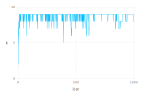

In [315]:
p = plot(y=sum(!isnan(P[:h2]),1),x=0:1000,Geom.line,Guide.xlabel("iter"),Guide.ylabel("k"))

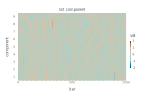

In [299]:
df = DataFrame(val=vec(P[:Lambda][:,1,:]),component=repeat(map(string,1:9),
outer=[1001]),iter=repeat([0:1000],inner=[9]))
df[:val][isnan(df[:val])] = 0;

plot(df,x="iter",y="component",color="val",Geom.rectbin,Guide.title("1st component"))

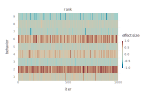

In [332]:
df = DataFrame(effectsize=vec(P[:B][:,1,:]),behavior=repeat(map(string,1:9),
outer=[1001]),iter=repeat([0:1000],inner=[9]))
df[:effectsize][isnan(df[:effectsize])] = 0;

plot(df,x="iter",y="behavior",color="effectsize",Geom.rectbin,Guide.title("rank"))

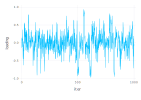

In [319]:
plot(y=P[:Lambda][1,1,:],x=0:1000,Geom.line,Guide.xlabel("iter"),Guide.ylabel("loading"))

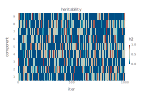

In [222]:
df = DataFrame(h2=vec(P[:h2]),component=repeat(map(string,1:9),
outer=[1001]),iter=repeat([0:1000],inner=[9]))
df[:h2][isnan(df[:h2])] = 0;

plot(df,x="iter",y="component",color="h2",Geom.rectbin,Guide.title("heritability"))

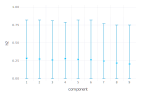

In [271]:
df = DataFrame(h2 = Array(Float64,9),cilow = Array(Float64,9),cihigh = Array(Float64,9),
component=map(string,[1:9]));
for i in 1:9;
    moo = P[:h2][i,:][!isnan(P[:h2][i,:])];
    df[:h2][i] = mean(moo); df[:cilow][i],df[:cihigh][i] = quantile(moo,[0.1,0.9]);
end
plot(df,y="h2",x="component",ymin="cilow",ymax="cihigh",Geom.point,Geom.errorbar)

In [291]:
priors[:df] = 5; # degrees of freedom for t-distribution of ARD prior on factor loadings
priors[:ad1] = 5; priors[:bd1] = 1/100; # inverse gamma hyperparamters for first factor shrinkage multiplier (/delta_1)
priors[:ad2] = 3; priors[:bd2] = 1; # inverse gamma hyperparamters for remaining factor shrinkage multiplier (/delta_i, i \in 2...k)


1

In [292]:
burn = 0; thin = 100; iter = 10001;
P2,priors = BSFG_sampler(X,Y,A,Z,burn,thin,iter,priors);

10001/10001; 6 factors
elapsed time: 51.668249637 seconds


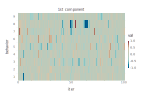

In [320]:
df = DataFrame(val=vec(P2[:Lambda][:,1,:]),behavior=repeat(map(string,1:9),
outer=[101]),iter=repeat([0:100],inner=[9]))
df[:val][isnan(df[:val])] = 0;

plot(df,x="iter",y="behavior",color="val",Geom.rectbin,Guide.title("1st component"))

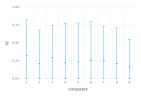

In [290]:
df = DataFrame(h2 = Array(Float64,9),cilow = Array(Float64,9),cihigh = Array(Float64,9),
component=map(string,[1:9]));
for i in 1:9;
    moo = P2[:h2][i,:][!isnan(P2[:h2][i,:])];
    df[:h2][i] = mean(moo); df[:cilow][i],df[:cihigh][i] = quantile(moo,[0.1,0.9]);
end
plot(df,y="h2",x="component",ymin="cilow",ymax="cihigh",Geom.point,Geom.errorbar)

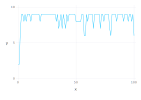

In [296]:
plot(y=sum(!isnan(P2[:h2]),1),x=0:100,Geom.line)